In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle

In [3]:

 

# Import h= (yaw,pitch)
with open("/content/drive/My Drive/h_list.txt", "rb") as fp:   # Unpickling
    h = pickle.load(fp)

# Import fl
with open("/content/drive/My Drive/features_left512.txt", "rb") as fp:   # Unpickling
    features_left = pickle.load(fp)

# Import fr
with open("/content/drive/My Drive/features_right512.txt", "rb") as fp:   # Unpickling
    features_right = pickle.load(fp)

# Import target gaze
with open("/content/drive/My Drive/gaze.txt", "rb") as fp:   # Unpickling
    gazes = pickle.load(fp)


In [ ]:
# Import l_imgs
"""
with open("/content/drive/My Drive/l_imgs.txt", "rb") as fp:   # Unpickling
    l_imgs = pickle.load(fp)

for i in range(len(l_imgs)):
    if (l_imgs[i]).all==0 : 
      print("\n eye_not_detected: ", i )
"""

In [4]:
import numpy as np
from os.path import dirname, join as pjoin
import scipy.io as sio
import cv2
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.patches as patches
import math
from math import *
from torch.utils.data import Dataset
import torchvision
import torch.optim as optim
from torchvision import models 
from torchvision import transforms
import torch.nn as nn
from PIL import Image
from matplotlib import cm
import torch
from torch.utils.data.sampler import SubsetRandomSampler
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
h2=torch.as_tensor(h).cuda()

In [6]:
gazes2=torch.as_tensor(np.array(gazes)).cuda()

In [7]:
data_in = torch.cat((h2,features_right, features_left), 1)

In [8]:
data_in2= data_in.clone().detach()

In [9]:
data_in2 = ((data_in2.T - data_in2.mean(axis = 1))/data_in2.std(axis = 1)).T

In [10]:

class MLPDataset(Dataset):
    """prep_data_for_MLP."""

    def __init__(self, data_in,gaze, transform=None):
        self.data_in = data_in
        self.target = gazes
        self.transform = transform



    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        x = self.data_in[idx]
        y=  self.target[idx]
        if self.transform:
              x = self.transform(x)
        #sample = {'input': x, 'gaze': y}
        return x,y

In [11]:
from torch.utils.data import Dataset, DataLoader

In [12]:
preprocess = transforms.Compose([
        transforms.Lambda(lambda x: x.double()),

        ])
dataset = MLPDataset(data_in2,gazes2,transform=preprocess)

In [13]:
validation_split = .2
shuffle_dataset = True
random_seed= 42
batch_size= 128
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [14]:
#input tensor size
tensor_size= len(features_left[0])*2+len(h[0])

In [15]:
#Function to create a Pretrained Resnet Model with a Fully Connected Layer
# (out_1: ouput of 1st layer), (out_2: ouput of 2nd layer)
def createModel_MLP(hidden,tensor_size):
    model = nn.Sequential(
      nn.Flatten(),
      nn.Linear(tensor_size, hidden),
      nn.ReLU(),
      #nn.Linear(hidden, 128),
      #nn.ReLU(),
      nn.Linear(hidden, 3 ),
    )
    
    model.double() #double to set variables to double
    #Sending the device to the GPU if avaliable
    model.to(device)

    return model

Starting training
Epoch Number: 0
loss: 15.918250044883417
val loss: 3.517362549864483
Epoch Number: 1
loss: 14.000605320885864
val loss: 3.4728191968917286
Epoch Number: 2
loss: 13.683991921139413
val loss: 3.4199362740660204
Epoch Number: 3
loss: 13.613116990481302
val loss: 3.4484889945908987
Epoch Number: 4
loss: 13.471515285664696
val loss: 3.4163530142920253
Epoch Number: 5
loss: 13.3739641164564
val loss: 3.3746925606672
Epoch Number: 6
loss: 13.279116256634447
val loss: 3.3872609584606614
Epoch Number: 7
loss: 13.260420189139992
val loss: 3.431188402216049
Epoch Number: 8
loss: 13.307366806445156
val loss: 3.412671600431235
Epoch Number: 9
loss: 13.202104574888294
val loss: 3.3279668097428945
Epoch Number: 10
loss: 13.128874803684166
val loss: 3.3535822006303215
Epoch Number: 11
loss: 13.127088154353025
val loss: 3.313847429820264
Epoch Number: 12
loss: 13.116636626799782
val loss: 3.3352470654282453
Epoch Number: 13
loss: 13.122716126540508
val loss: 3.320514424925971
Epoch Nu

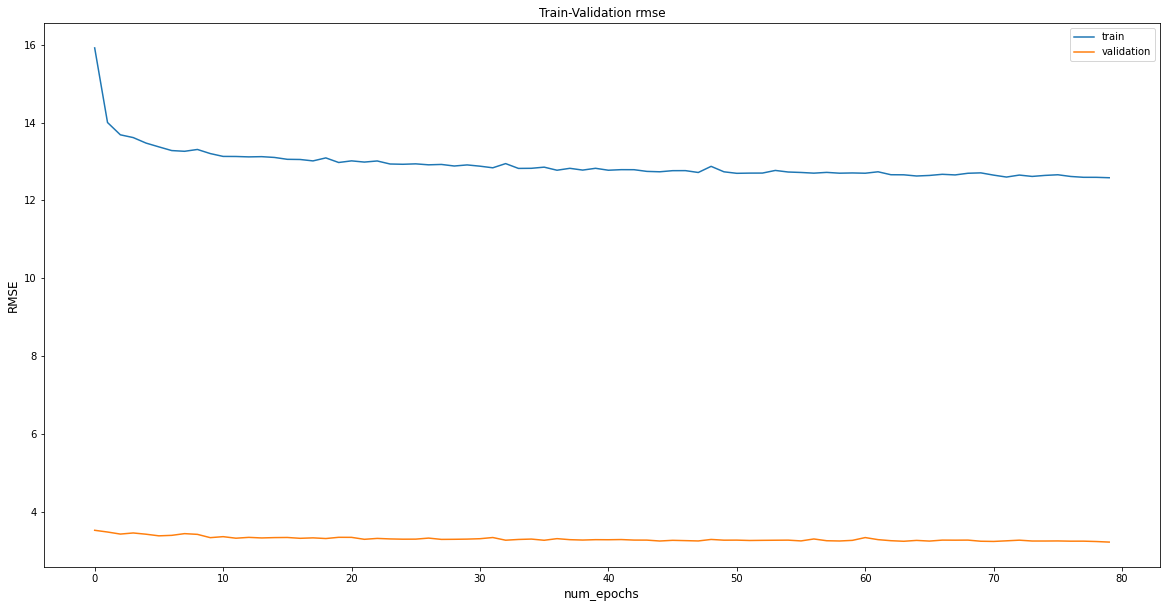

In [16]:
#Function to handle training
#(model: model to train), (criterion: loss function for the model), (optimizer, what optimizer to use)
def train(model, criterion, optimizer, file, epochs=80, trainLoss=[], validationLoss=[]):
    #device = torch.device("cpu")
    print("Starting training")
    for epoch in range(epochs):
        print(f"Epoch Number: {epoch}")

        testAccuracy = 0
        totalLoss = 0

        for i, data in enumerate(train_loader, 0):
            #Put model into training mode
            model.train()
            #batch= next(iter(train_loader))
            x=data[0]
            y=data[1].to(device)
            #Zero out gradients
            optimizer.zero_grad()
            #Make a prediction
            y_hat = model(x)
            
            #Calculate the loss
            loss = criterion(y_hat, y)
            #l = torch.sqrt(loss)
            #Update the total loss
            totalLoss += loss
            #Initiate backpropagation
            loss.backward()
            
            #Update parameters
            optimizer.step()

            #testAccuracy += (y_hat == y).sum().item()
        trainLoss.append(totalLoss)
        print(f"loss: {totalLoss}")
        
        valAccuracy = 0
        totalLoss = 0
        
        
        for j, data in enumerate(validation_loader, 0):
            # Put the model into evaluation mode
            #banch= next(iter(validation_loader))
            x=data[0]
            y=data[1].to(device)
            model.eval()
            y_pred= model(x)
            #print(y_pred)
            loss = criterion(y_pred, y)
            #l = torch.sqrt(loss)
            totalLoss += loss
        print(f"val loss: {totalLoss}")
        validationLoss.append(totalLoss)
        #Save our model for each epoch
    fig = plt.figure(figsize=(20,10))
    plt.title("Train-Validation rmse")
    plt.plot(trainLoss, label='train')
    plt.plot(validationLoss, label='validation')
    plt.xlabel('num_epochs', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.legend(loc='best')
    plt.savefig('MLP_RMSE_normalized1026.png')


    torch.save(model.state_dict(), file)
    torch.save(model.state_dict(), "/content/drive/MyDrive/"+file)
    return trainLoss, validationLoss, model

#Create a model using our function
model = createModel_MLP(256,tensor_size)
#Define our loss and optimizers
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)
#Specify output file name
file = "MLP.pth" #save model

#Try to use Colab's GPU here, otherwise it will take a long time to train.
output = train(model, criterion, optimizer, file)